In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Sheet, PlanarGeometry
from tyssue.draw import sheet_view

from scipy.integrate import solve_ivp
geom = PlanarGeometry

(0, 1)

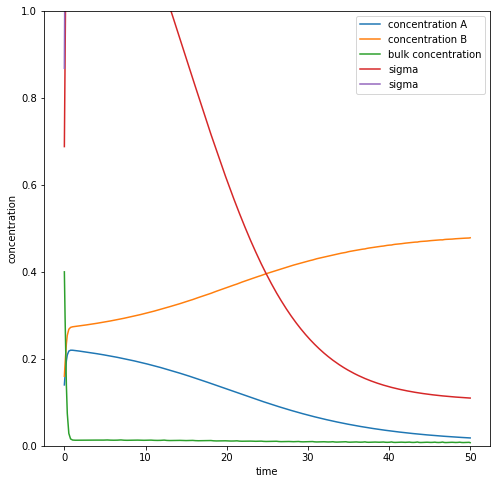

In [2]:
recrutement = 0.  # k
meca_sens = 1.  # k'

auto_catalytique = 0. # k"
relax_rate = 0.1 # 1 / τ 
N = 1.
c_0 = 0.1
length = 1.
susceptiblity=300.
desorption = relax_rate    
#Cas symétrique

length = 1. # \ell

def sigma_0():
    #return ((relax_rate * length**2 * c_0)/(N - 4 * length * c_0)
    #- (recrutement + auto_catalytique) * c_0) / susceptiblity 
    return 0.1

def c_bulk(concs):
    return (N - 2*(length*concs).sum()) / length**2

def tension(concs):
#    tension = sigma_0() * np.exp(susceptiblity * (concs - c_0))
    tension = sigma_0() * (1 + susceptiblity * concs ** 2)
    return tension



def ode(t, concs):
    c_B = c_bulk(concs)
    sigma = tension(concs)
    
    #concs_dot = (((recrutement + auto_catalytique) @ concs + sigma) * c_B - concs*relax_rate)
    concs_dot = - desorption * concs
    concs_dot += ((recrutement + auto_catalytique) * concs + meca_sens * sigma ) * c_B
    return concs_dot



concs_0 = np.array([0.14, 0.16])

res = solve_ivp(ode, (0, 50), concs_0, )

fig, ax = plt.subplots()
times = res['t']
conc = res['y'][0, :]

conc2 = res['y'][1, :]

c_B = np.array([c_bulk(c+c2) for c, c2 in zip(conc, conc2)])

sigma = np.array([tension(np.array((c,c2))) for c, c2 in zip(conc, conc2)])


ax.plot(times, conc, label="concentration A")
ax.plot(times, conc2, label="concentration B")


#ax.plot(times, np.ones_like(times)*N/length, label="max concentration")

ax.plot(times, c_B, label="bulk concentration")

ax.plot(times, sigma, label="sigma")
#ax.plot(times, 2*(conc + conc2) + c_B,label='conc_tot')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('concentration')
fig.set_size_inches((8, 8))
#ax.set_xlim(0, 4)
ax.set_ylim(0, 1)




## Cas général sur un tissu 2D

* Conservation de la quantité de protéines

$$N_\alpha = \sum_{ij}\ell_{ij}c_{ij} + A_\alpha c_\alpha\\
  c_\alpha = \frac{1}{A_\alpha}(N_\alpha - \sum_{ij}\ell_{ij}c_{ij})
$$

(On écrit $c_\alpha$ plutôt que $c_\mbox{bulk}$)

$$
\frac{d(\ell_{ij}c_{ij})}{dt} = - \alpha \ell_{ij} c_{ij} + \left(
    k\bar{c_{ij}} + k' \sigma(c_{ij}) + k'' c_{ij}\right) \ell_{ij} c_\alpha 
$$



In [3]:
from tyssue import config, Sheet, PlanarGeometry, History
from tyssue.dynamics import effectors, model_factory
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.utils import data_at_opposite
from tyssue.solvers import QSSolver
from tyssue.topology import auto_t1, auto_t3 
from tyssue.solvers.base import TopologyChangeError

In [4]:
import sys
import logging
log = logging.getLogger('tyssue')
h = logging.StreamHandler(sys.stdout)
#log.setLevel("DEBUG")
#log.addHandler(h)

In [5]:
from itertools import count

class ChemGeom(PlanarGeometry):
    
    @classmethod
    def update_all(cls, sheet):
        super().update_all(sheet)
        cls.update_concentrations(sheet)
        cls.update_tension(sheet)
        
    @staticmethod
    def update_tension(sheet):
        sheet.edge_df['line_tension'] = sheet.edge_df.eval(
            'susceptibility * concentration') + sheet.settings["tension0"]

    @staticmethod
    def update_concentrations(sheet):
        sheet.edge_df['concentration'] = sheet.edge_df.eval("protein_number / length")
        sheet.face_df['concentration'] = (
            sheet.face_df['total_protein']
            - sheet.sum_face(sheet.edge_df["protein_number"]).values.ravel()
        ) / sheet.face_df["area"]
        sheet.edge_df['o_protein_number'] = data_at_opposite(
            sheet, sheet.edge_df["protein_number"], free_value=0)
        sheet.edge_df['b_concentration'] = sheet.upcast_face('concentration')
        
class Compression(effectors.AbstractEffector):
    
    @staticmethod
    def energy(sheet):
        return sheet.vert_df.eval('0.5 * compression * x**2')
        
    @staticmethod
    def gradient(sheet):
        grad = sheet.vert_df[sheet.coords].copy()
        grad.columns = ['gx', 'gy']
        grad['gy'] = 0
        grad['gx'] = sheet.vert_df.eval("compression * x")
        return grad, None
        
            
class Extension(effectors.AbstractEffector):
    
    @staticmethod
    def energy(sheet):
        return sheet.vert_df.eval('-0.5 * extension * y**2')
        
    @staticmethod
    def gradient(sheet):
        grad = sheet.vert_df[sheet.coords].copy()
        grad.columns = ['gx', 'gy']
        grad['gx'] = 0
        grad['gy'] = sheet.vert_df.eval("-extension*y")
        return grad, None
        

def set_pos(sheet, geom, pos):
    
    vert_pos = pos[:sheet.Nv * sheet.dim].reshape((sheet.Nv, -1))
    sheet.vert_df[sheet.coords] = vert_pos
    protein_number = pos[sheet.Nv * sheet.dim:]
    sheet.edge_df["protein_number"] = protein_number
    geom.update_all(sheet)

MAX_ITER = 30

        
class ViscousSolver:

    def __init__(self, eptm, geom, model,
                 with_collisions=False, with_t1=False, with_t3=False):
        
        self._set_pos = set_pos
        if with_collisions:
            self._set_pos = auto_collisions(self._set_pos)
        if with_t1:
            self._set_pos = auto_t1(self._set_pos)
        if with_t3:
            self._set_pos = auto_t3(self._set_pos)
        self.rearange = with_t1 or with_t3
        self.eptm = eptm
        self.geom = geom
        self.model = model
        self.history = History(
            eptm,
            extra_cols={
                "edge": ["concentration", "stress", "length"],
                "face": ["concentration"]
            }
        )
        self.prev_t = 0
        self.solver_t = np.empty((0,))
        
    def set_pos(self, pos):
        return self._set_pos(self.eptm, self.geom, pos)
        
    def ode_func(self, t, pos):
        
        self.set_pos(pos)
        
        grad = model.compute_gradient(self.eptm)
        self.eptm.edge_df["stress"] = (
            np.linalg.norm(
                self.eptm.upcast_srce(grad)
                * self.eptm.edge_df[['ux', 'uy']].values, axis=1)
            + np.linalg.norm(
                self.eptm.upcast_trgt(grad)
                * self.eptm.edge_df[['ux', 'uy']].values, axis=1)
        )

        dot_positions = - (grad.values / self.eptm.vert_df['viscosity'].values[:, None]).ravel()
        dot_concentrations = self.eptm.edge_df.eval(
            "- desorption * protein_number"
            " + ("
            "auto_catalytic * protein_number"
            "+ mechano_sensitivity * stress * length"
            "+ recrutment * o_protein_number"
            ") * b_concentration").values

        return np.concatenate((dot_positions, dot_concentrations))

    def solve(self, t):
        res = {"message": "Not started", "success": False}
        for i in count():
            if i == MAX_ITER:
                res['message'] = res['message'] + "\nMax number of iterations reached!"
                return res
            try:
                _prev_t = self.prev_t
                self.prev_t = t
                pos0 = np.concatenate((sheet.vert_df[sheet.coords].values.ravel(),
                                       sheet.edge_df['protein_number'].values))
                
                res = solve_ivp(self.ode_func, (_prev_t, t), pos0)
                self.solver_t = np.concatenate((self.solver_t, res['t']))
                return res
            except TopologyChangeError:
                print(f"Topology changed at time {t}")
                self.ode_mat = get_ode_mat(eptm)



Reseting column is_alive of the face dataset with new specs
Reseting column is_active of the vert dataset with new specs


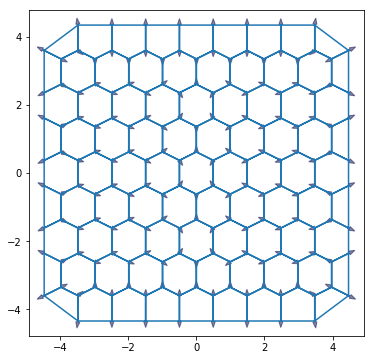

In [6]:
sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0)

PlanarGeometry.update_all(sheet)
solver = QSSolver(with_t1=True, with_t3=True, with_collisions=False)
sheet.sanitize(trim_borders=True)


sheet.remove(sheet.cut_out([[0, 10], [0, 10]]), trim_borders=True)


PlanarGeometry.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
PlanarGeometry.center(sheet)
PlanarGeometry.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()



model = model_factory([effectors.LineTension,
                       #effectors.FaceContractility,
                       Compression,
                       effectors.FaceAreaElasticity])



polarity_specs = {
    "edge": {
        "concentration": 0.1,
        "protein_number": 0.1,
        "o_protein_number": 0.,
        "b_concentration": 0.,
        "recrutment": 0.,
        "auto_catalytic": 0.,
        "susceptibility": 0.01,
        "desorption": 0.1,
        "mechano_sensitivity": 2.0,
        "stress": 0.,
    },
    "face": {
        "total_protein": 1.,
        "concentration": 1.
    }
}

dynamics_specs = {
    "edge": {
        "is_active": 1,
        "line_tension": 0.02,
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    },
    "face": {
        "is_alive": 1,
        "area_elasticity": 1.,
        "prefered_area": 1.,
        "contractility": 0.12
    },
    "vert": {
        "compression": 1e-3,
        "extension": 1.,
        "is_active": 1,
        "viscosity": 1e-2,
    },
    "settings": {
        "tension0": 0.01,
        "threshold_length": 1e-6
    }
}


sheet.update_specs(polarity_specs, reset=True)
sheet.update_specs(dynamics_specs, reset=True)
sheet.get_opposite()
ChemGeom.update_all(sheet)
# strat with uniform concentration
#sheet.edge_df["protein_number"] = sheet.edge_df.eval("concentration * length")


fig, ax = plot_forces(sheet, PlanarGeometry, model, list('xy'), scaling=0.1)
fig.set_size_inches(6, 6)

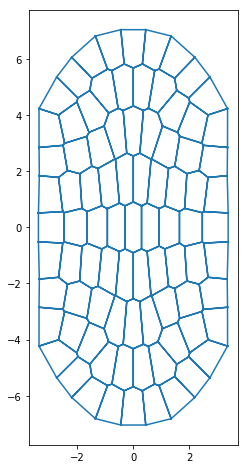

In [14]:
solver = QSSolver(with_t1=True, with_t3=True, with_collisions=False)
res = solver.find_energy_min(sheet, PlanarGeometry, model)

fig, ax = sheet_view(sheet, mode='quick',)
fig.set_size_inches((8, 8))


In [15]:

sheet.settings["threshold_length"] = 1e-2


solver = ViscousSolver(sheet, ChemGeom, model, with_t1=True)


In [16]:
res = solver.solve(0.1)

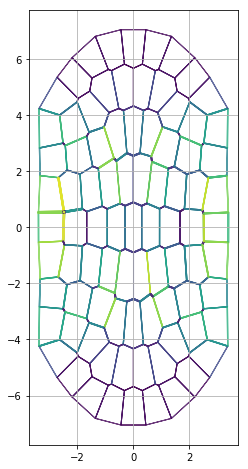

In [17]:
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": np.log(sheet.edge_df['protein_number']),
        'head_width':0,
        'width': (1 + 3*sheet.edge_df['stress']/sheet.edge_df['stress'].max()),
        "cmap": "Greys"},
    vert={"visible": False})


potential_collisions = sheet.edge_df[sheet.edge_df['sub_area'] <= 0]
ax.plot(sheet.vert_df.loc[potential_collisions.srce, "x"], sheet.vert_df.loc[potential_collisions.srce, "y"], "ko")
ax.plot(sheet.vert_df.loc[potential_collisions.trgt, "x"], sheet.vert_df.loc[potential_collisions.trgt, "y"], "r+")

#ax.set_xlim(1.65, 1.9)
#ax.set_ylim(3.5, 3.4)


fig.set_size_inches((8, 8))

In [11]:
potential_collisions['length']

Series([], Name: length, dtype: float64)

In [12]:
from tyssue.collisions import self_intersections

In [13]:
sheet.vert_df['z'] = np.random.normal(0, 1e-3, sheet.Nv)
edges = self_intersections(sheet)

In [14]:
edges.shape


(3070, 2)

,srce,trgt,face
edge,,,
369,116,144,16
392,0,50,73
393,50,0,64


In [145]:
edges

array([[105,  37],
       [106,  37],
       [ 23,  37],
       ...,
       [130, 132],
       [127, 131],
       [127, 132]])

In [146]:
sheet.edge_df.shape

(472, 31)

In [131]:
sheet.edge_df.sub_area.min()

-0.04792521849323898

In [97]:
sheet.edge_df["mechano_sensitivity"] = 2.0


In [98]:

pos_0 = np.concatenate((sheet.vert_df[sheet.coords].values.ravel(),
                        sheet.edge_df['protein_number'].values))
ode = get_ode(sheet, history)

res = solve_ivp(ode, (0, 10.), pos_0)


KeyboardInterrupt: 

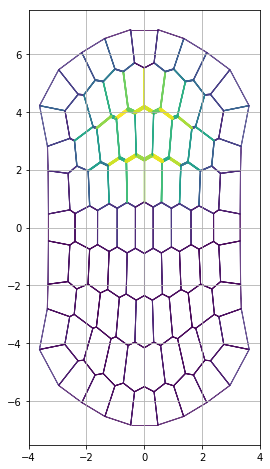

In [99]:
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": np.log(sheet.edge_df['protein_number']),
        'head_width':0,
        'width': (1 + 3*sheet.edge_df['stress']/sheet.edge_df['stress'].max()),
        "cmap": "Greys"},
    vert={"visible": False})
fig.set_size_inches((8, 8))

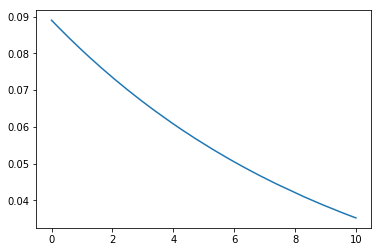

In [94]:
fig, ax = plt.subplots()

ax.plot(res.t, res.y[sheet.Nv*sheet.dim*2:, :].mean(axis=0))


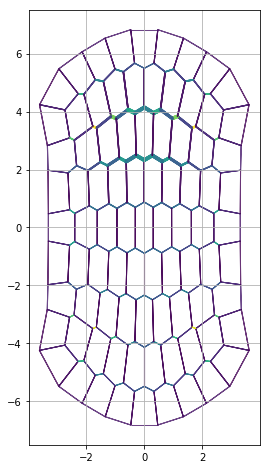

In [95]:

fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": sheet.edge_df['concentration'],
        'head_width':0,
        'width': (1 + 3*sheet.edge_df['stress']/sheet.edge_df['stress'].max())},
    vert={"visible": False})
fig.set_size_inches((8, 8))

(-0.0001, 0.001)

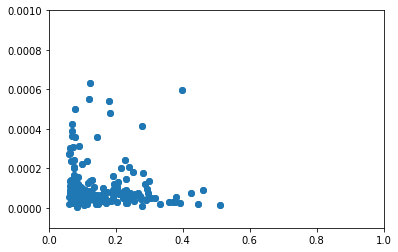

In [350]:
fig, ax = plt.subplots()

ax.scatter(sheet.edge_df['concentration'], sheet.edge_df['stress'])
ax.set_xlim(0, 1)
ax.set_ylim(-1e-4, 1e-3)


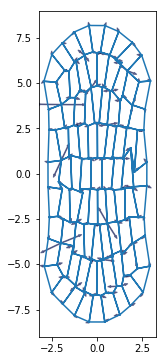

In [61]:
fig, ax = plot_forces(sheet, PlanarGeometry, model, list('xy'), scaling=1)
fig.set_size_inches(6, 6)